In [2]:
import pandas as pd

df = pd.read_csv('/home/pablo/active-learning-pablo/data/datasets/cflw_large_without_duplicates.csv', on_bad_lines='warn')
df.head()

,host_id,page_id,page_version_id,RelatedTagsArray,Cybercrime,Drugs / Narcotics,Financial Crime,Goods and Services,Sexual Abuse,Violent Crime,html,tree
0,59895,40,26837,"['Bitcoin (BTC)', 'English', 'Financial Crime'...",0,0,1,0,0,0,\n\n\n100x Your Coins in 24 Hours - Officially...,{html {head meta meta meta meta title link li...
1,59906,44,46435,"['English', 'Financial Crime', 'Gambling', 'Ma...",0,0,1,0,0,0,\n\nHACK-HELP\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nM...,{html {head title link link meta meta link li...
2,59930,48,22406700,"['Community', 'Cybercrime', 'Forum', 'Gerki Ma...",1,0,0,0,0,0,\n\n\n\n\n\n\n\n\n\nGerki - ÃÂ¥ÃÂ°ÃÂºÃÂµÃ...,{html {head style meta meta meta base script ...
3,60064,86,17558,"['Cannabis', 'Community', 'Drugs / Narcotics',...",0,1,0,0,0,0,\n\n\n\nCGMC\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\...,{html {head meta title link link style} {body...
4,60073,88,18512,"['Carding', 'Credit Cards', 'English', 'Financ...",0,0,1,0,0,0,\n0day 1337day Agreement - 0day 1337day Inj3...,{html {head meta title meta meta link link li...


/home/pablo/active-learning-pablo/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


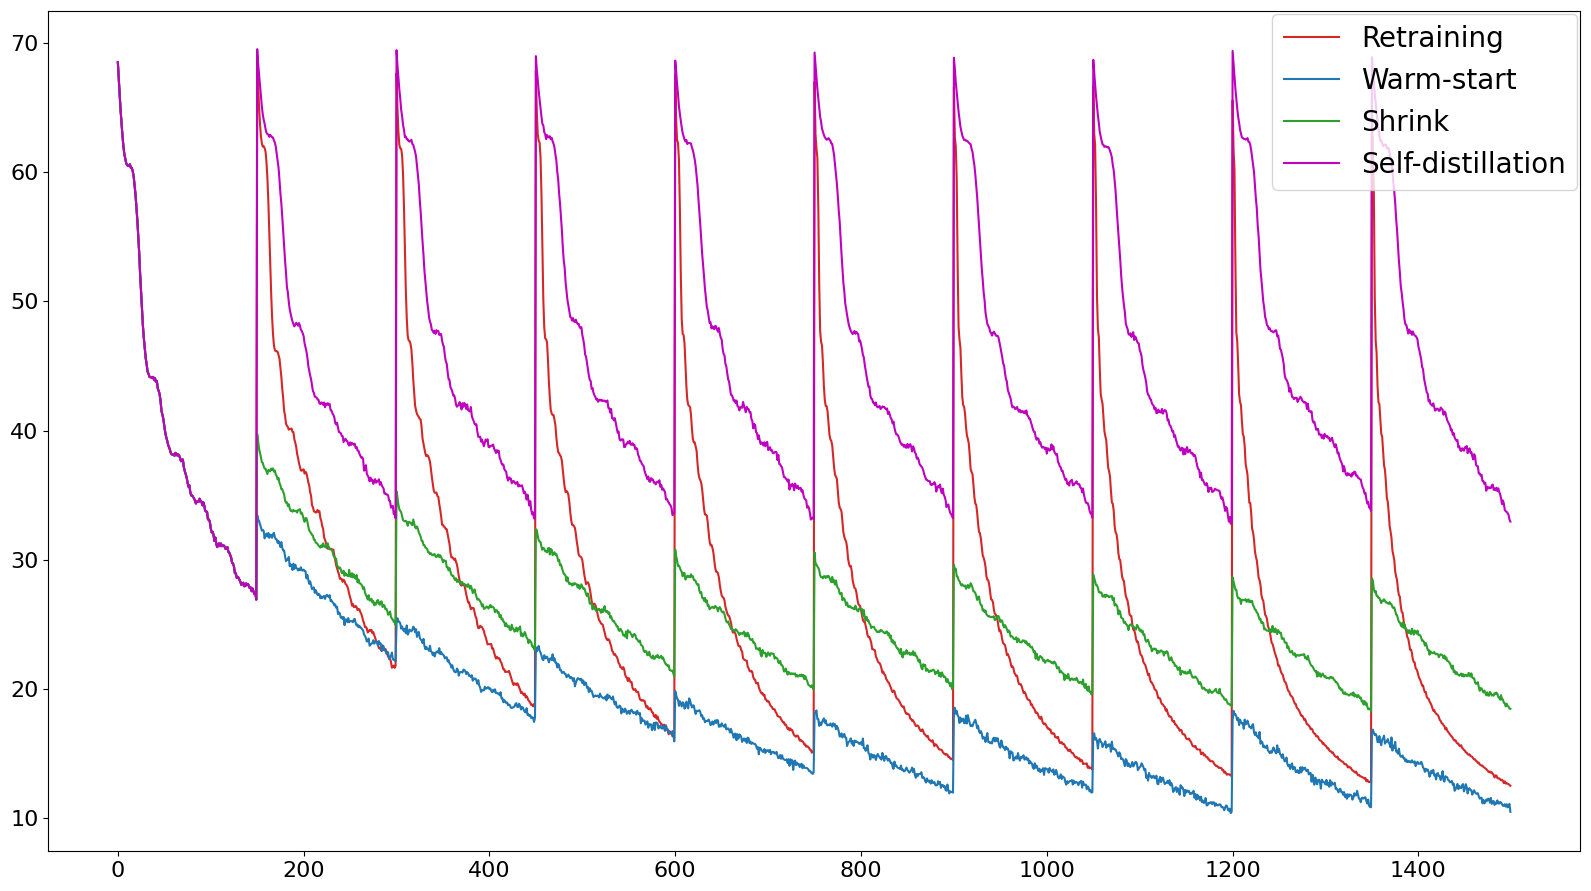

In [3]:
import os
import pandas as pd
import numpy as np
import sys
sys.path.append("../") # go to parent dir


from src.preprocessing.text_extraction import TextExtraction
from src.preprocessing.text_preprocessing import TextPreprocessor
from src.vectorization.vectorization_sbert import TextVectorization
from src.classification.helpers import split_train_val_test
from src.classification.active_sbert import ClassificationManagerSBERT
from src.classification.plotting import plot_progress

import copy

import numpy as np

In [5]:
df = df.drop([ 'host_id', 'page_id', 'page_version_id',
       'RelatedTagsArray', 'tree'], axis = 1)
df.head()

,Cybercrime,Drugs / Narcotics,Financial Crime,Goods and Services,Sexual Abuse,Violent Crime,html
0,0,0,1,0,0,0,\n\n\n100x Your Coins in 24 Hours - Officially...
1,0,0,1,0,0,0,\n\nHACK-HELP\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nM...
2,1,0,0,0,0,0,\n\n\n\n\n\n\n\n\n\nGerki - ÃÂ¥ÃÂ°ÃÂºÃÂµÃ...
3,0,1,0,0,0,0,\n\n\n\nCGMC\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\...
4,0,0,1,0,0,0,\n0day 1337day Agreement - 0day 1337day Inj3...


In [15]:
import re
df['html'] = df['html'].map(lambda x: re.sub(r"https?://\S+|www\.\S+","",x) )
df['html'] = df['html'].map(lambda x: re.sub("["
                                                                                   u"\U0001F600-\U0001F64F"
                                                                                   u"\U0001F300-\U0001F5FF"  
                                                                                   u"\U0001F680-\U0001F6FF" 
                                                                                   u"\U0001F1E0-\U0001F1FF"  
                                                                                   u"\U00002702-\U000027B0"
                                                                                   u"\U000024C2-\U0001F251"
                                                                                   "]+","", x, flags=re.UNICODE))
df['html'] = df['html'].map(lambda x: re.sub(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",x))
df['html'] = df['html'].map(lambda x: re.sub(r"<.*?>","",x))
df['html'] = df['html'].map(lambda x: re.sub(r"\"\"", "\"",x)) 
df['html'] = df['html'].map(lambda x: re.sub(r"^\"", "",x))  
df['html'] = df['html'].map(lambda x: re.sub(r"\"$", "",x))
df['html'] = df['html'].map(lambda x: re.sub(r"[^a-zA-Z0-9\s][^a-zA-Z0-9\s]+", " ",x))
df['html'] = df['html'].map(lambda x: re.sub(r"[^a-zA-Z0-9\s\"\',:;?!.()]", " ",x))

df['html'] = df['html'].map(lambda x: re.sub(r"\s\s+", " ",x))

text_preprocessor = TextPreprocessor()
df['html'] = df['html'].apply(text_preprocessor.preprocess_data)
df = df.drop(df[df["html"].map(len) == 0].index)
df.head()

NameError: name 'TextPreprocessor' is not defined

In [13]:
text_vectorizer = TextVectorization()
X = text_vectorizer.vectorize(df["html"].values)
y = df.loc[:-1].values


In [15]:
print(X.shape)
y =  df.iloc[:,:-1]

print(y.shape)

(10236, 384)
(10236, 6)


In [16]:
df_train = pd.DataFrame(np.concatenate((X, y), axis=1))
df_train.to_csv(r'/home/pablo/active-learning-pablo/data/datasets/cflw_final.csv', index=False)

In [17]:
df_train.head

<bound method NDFrame.head of             0         1         2         3         4         5         6    \
0     -0.395900  0.208611 -0.292372 -0.077810 -0.116024 -0.466825 -0.186791   
1     -0.312779 -0.048467 -0.473293 -0.248513 -0.068076 -0.129844  0.492150   
2     -0.548504  0.249276 -0.378511 -0.412711  0.133176 -0.054894  0.301208   
3     -0.541543 -0.134605 -0.440592 -0.000018 -0.218069  0.321872 -0.010070   
4     -0.358616 -0.116082 -0.164695 -0.549616  0.155650  0.068418 -0.048296   
...         ...       ...       ...       ...       ...       ...       ...   
10231 -0.192316  0.245291 -0.130056  0.176203 -0.342688  0.200265  0.378296   
10232 -0.083085  0.140752 -0.075669  0.012370 -0.322444 -0.267595  0.318321   
10233 -0.385892 -0.239933 -0.454792 -0.089524  0.084119  0.122638 -0.135661   
10234 -0.082928 -0.058157 -0.119925 -0.054896  0.078068 -0.343208 -0.039242   
10235 -0.899426 -0.161817 -0.427261 -0.152492  0.091772  0.172238  0.464684   

            7        

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
from src.classification.helpers import split_train_val_test

labels = [
        'Cybercrime',
       'Drugs / Narcotics', 'Financial Crime', 'Goods and Services',
       'Sexual Abuse', 'Violent Crime']
df = pd.read_csv('/home/pablo/active-learning-pablo/data/datasets/cflw_final.csv')
financial_df = df[df['386'] == 1]
non_financial_df = df[df['386'] == 0]
#df = pd.concat([non_financial_df,financial_df.sample(10_000)])
y = df.iloc[:, -len(labels) :].values
X = df.iloc[:, : -len(labels)].values

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(
        X, y, train_frac=0.7, val_frac=0.01, test_frac=0.29
    )


sum_labels_train = y_train.sum(axis = 0)
sum_labels_test = y_test.sum(axis = 0)
sum_labels_val = y_val.sum(axis = 0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
 
# creating the bar plot
ax1.bar(labels, sum_labels_val, color = 'b')
ax1.set(xlabel="Label", ylabel="Number of samples")
ax1.set_title("Initial data", fontsize=18)
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

ax2.bar(labels, sum_labels_train, color = 'g')
ax2.set(xlabel="Label", ylabel="Number of samples")
ax2.set_title("Unlabeled data",fontsize=18)
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')

ax3.bar(labels, sum_labels_test, color = 'r')
ax3.set(xlabel="Label", ylabel="Number of samples")
ax3.set_title("Test data",fontsize=18)
plt.setp(ax3.get_xticklabels(), rotation=30, horizontalalignment='right')

fig.savefig('/home/pablo/active-learning-pablo/data/datasets/statistics/labels.png')

In [ ]:
number_train = y_train.sum(axis = 1)
unique_train, counts_train = np.unique(number_train, return_counts=True)
number_test = y_test.sum(axis = 1)
unique_test, counts_test = np.unique(number_test, return_counts=True)
number_val = y_val.sum(axis = 1)
unique_val, counts_val = np.unique(number_val, return_counts=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
 
# creating the bar plot
ax1.bar(unique_val, counts_val, color = 'b')
ax1.set(xlabel="Number of labels", ylabel="Number of samples")
ax1.set_title("Labeled data",fontsize=18)
plt.setp(ax1.get_xticklabels(), rotation=0, horizontalalignment='right')

ax2.bar(unique_train, counts_train, color = 'g')
ax2.set(xlabel="Number of labels", ylabel="Number of samples")
ax2.set_title("Unlabeled data",fontsize=18)
plt.setp(ax2.get_xticklabels(), rotation=0, horizontalalignment='right')

ax3.bar(unique_test, counts_test, color = 'r')
ax3.set(xlabel="Number of labels", ylabel="Number of samples")
ax3.set_title("Test data",fontsize=18)
plt.setp(ax3.get_xticklabels(), rotation=0, horizontalalignment='right')

fig.suptitle("Frequency of labels")
fig.savefig('/home/pablo/active-learning-pablo/data/datasets/statistics/label_counts.png')


In [ ]:
labels = [
        'Cybercrime',
       'Drugs / Narcotics', 'Financial Crime', 'Goods and Services',
       'Sexual Abuse', 'Violent Crime']
nr = [3438, 7749, 82808, 7492, 1884, 1160]
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

ax.bar(labels,nr)
ax.set(xlabel="Label", ylabel="Number of samples")

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
from src.classification.helpers import split_train_val_test
import json

dist = pd.read_csv('/home/pablo/active-learning-pablo/results/test/active_learning/dark_wo_duplicates/sampling_size/classwise_distrib_sander.csv')
with open('/home/pablo/active-learning-pablo/results/test/active_learning/dark_wo_duplicates/sampling_size/classwise_result_sander.json', 'r') as f:
        metrics = json.load(f)

In [2]:
metrics['0']

{'0': {'Cybercrime': {'precision': 0.6136363636363636,
   'recall': 0.3767441860465116,
   'f1-score': 0.46685878962536026,
   'support': 430},
  'Drugs / Narcotics': {'precision': 0.6455142231947484,
   'recall': 0.6599552572706935,
   'f1-score': 0.6526548672566371,
   'support': 447},
  'Financial Crime': {'precision': 0.7357798165137615,
   'recall': 0.834257975034674,
   'f1-score': 0.7819304517387066,
   'support': 1442},
  'Goods and Services': {'precision': 0.5345622119815668,
   'recall': 0.33429394812680113,
   'f1-score': 0.4113475177304965,
   'support': 347},
  'Sexual Abuse': {'precision': 0.4444444444444444,
   'recall': 0.046511627906976744,
   'f1-score': 0.08421052631578947,
   'support': 86},
  'Violent Crime': {'precision': 0.2,
   'recall': 0.0136986301369863,
   'f1-score': 0.02564102564102564,
   'support': 73},
  'micro avg': {'precision': 0.6884422110552764,
   'recall': 0.6304424778761062,
   'f1-score': 0.6581670362158166,
   'support': 2825},
  'macro avg': 

In [7]:
cyber = []
drugs = []
financial = []
abuse = []
violent = []
goods = []


for i in range(33):
    cyber.append(metrics['0'][str(i)]['Cybercrime']['recall'])
    drugs.append(metrics['0'][str(i)]['Drugs / Narcotics']['recall'])
    financial.append(metrics['0'][str(i)]['Financial Crime']['recall'])
    abuse.append(metrics['0'][str(i)]['Sexual Abuse']['recall'])
    violent.append(metrics['0'][str(i)]['Violent Crime']['recall'])
    goods.append(metrics['0'][str(i)]['Goods and Services']['recall'])

In [4]:
nr_cyber = dist['Cybercrime'].values.tolist()


In [5]:
len(dist['Cybercrime'].values.tolist())

33

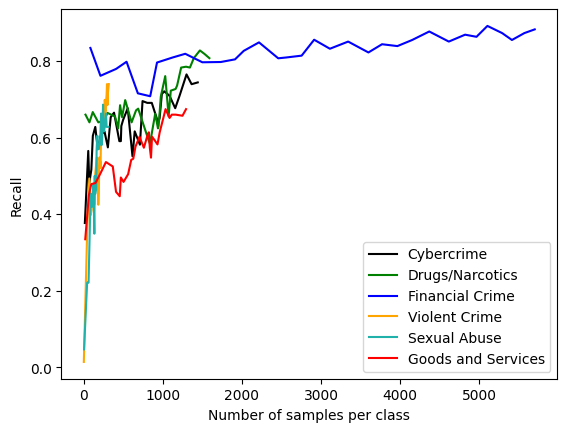

In [8]:
fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(dist['Cybercrime'].values.tolist(), cyber,c='k',label='Cybercrime',fillstyle='none')


ax.plot(dist['Drugs / Narcotics'].values.tolist(),drugs,c='g',label='Drugs/Narcotics',fillstyle='none')


ax.plot(dist['Financial Crime'].values.tolist(),financial,c='b',label='Financial Crime')


ax.plot(dist['Violent Crime'].values.tolist(),violent,c='orange',label='Violent Crime')


ax.plot(dist['Sexual Abuse'].values.tolist(),abuse,c='lightseagreen',label='Sexual Abuse')


ax.plot(dist['Goods and Services'].values.tolist(),goods,c='red',label='Goods and Services')

plt.legend()
ax.set_ylabel("Recall")
ax.set_xlabel("Number of samples per class")

fig.savefig(r'C:\Users\Pablo\OneDrive\Desktop\Pablo\uni\tfm\code\active-learning-pablo\results\plots\AL\dark\perf_by_class.png')
plt.show()

In [9]:
def plot_classification_scores(report, save_path):

    classes = list(report.keys())

    classes_to_exclude = ["micro avg", "macro avg", "weighted avg", "samples avg"]

    classes_to_plot = [c for c in classes if c not in classes_to_exclude]

    num_plots = len(classes_to_plot)

    num_rows = (num_plots + 1) // 3

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows), sharex=True)

    axes = axes.flatten()  # Flatten axes if there's only one row




    for i, class_name in enumerate(classes_to_plot):

        scores = report[class_name]

        precision = scores["precision"]

        recall = scores["recall"]

        f1_score = scores["f1-score"]

        support = scores["support"]




        ax = axes[i]

        sns.barplot(

            x=["Precision", "Recall", "F1-Score"],

            y=[precision, recall, f1_score],

            ax=ax,

        )

        ax.set_ylim(0, 1.1)

        ax.set_title(f"{class_name} (Support: {support})", fontsize=18)




        # Add bar labels

        for j, score in enumerate([precision, recall, f1_score]):

            ax.text(j, score, f"{score:.2f}", ha="center", va="bottom", fontsize=12)




        # Set x-axis labels and x-ticks

        ax.set_xticklabels(["Precision", "Recall", "F1-Score"], fontsize=12)

        ax.set_xlabel("Metrics")




        # Set y-axis label

        ax.set_ylabel("Score")




    # Set x-ticks for all subplots

    for ax in axes[:-2]:

        ax.xaxis.set_tick_params(which="both", labelbottom=True)




    # Hide extra subplots

    for j in range(num_plots, len(axes)):

        axes[j].axis("off")




    # Save the plot

    plt.tight_layout()

    plt.savefig(save_path)

In [18]:
metrics['0']['32']


{'Cybercrime': {'precision': 0.7980049875311721,
  'recall': 0.7441860465116279,
  'f1-score': 0.7701564380264742,
  'support': 430},
 'Drugs / Narcotics': {'precision': 0.7916666666666666,
  'recall': 0.8076062639821029,
  'f1-score': 0.7995570321151715,
  'support': 447},
 'Financial Crime': {'precision': 0.9164866810655148,
  'recall': 0.8828016643550625,
  'f1-score': 0.8993288590604027,
  'support': 1442},
 'Goods and Services': {'precision': 0.782608695652174,
  'recall': 0.6743515850144092,
  'f1-score': 0.7244582043343653,
  'support': 347},
 'Sexual Abuse': {'precision': 0.75,
  'recall': 0.627906976744186,
  'f1-score': 0.6835443037974683,
  'support': 86},
 'Violent Crime': {'precision': 0.782608695652174,
  'recall': 0.7397260273972602,
  'f1-score': 0.7605633802816901,
  'support': 73},
 'micro avg': {'precision': 0.8548026805658973,
  'recall': 0.8127433628318584,
  'f1-score': 0.8332426056976955,
  'support': 2825},
 'macro avg': {'precision': 0.8035626210946168,
  'reca

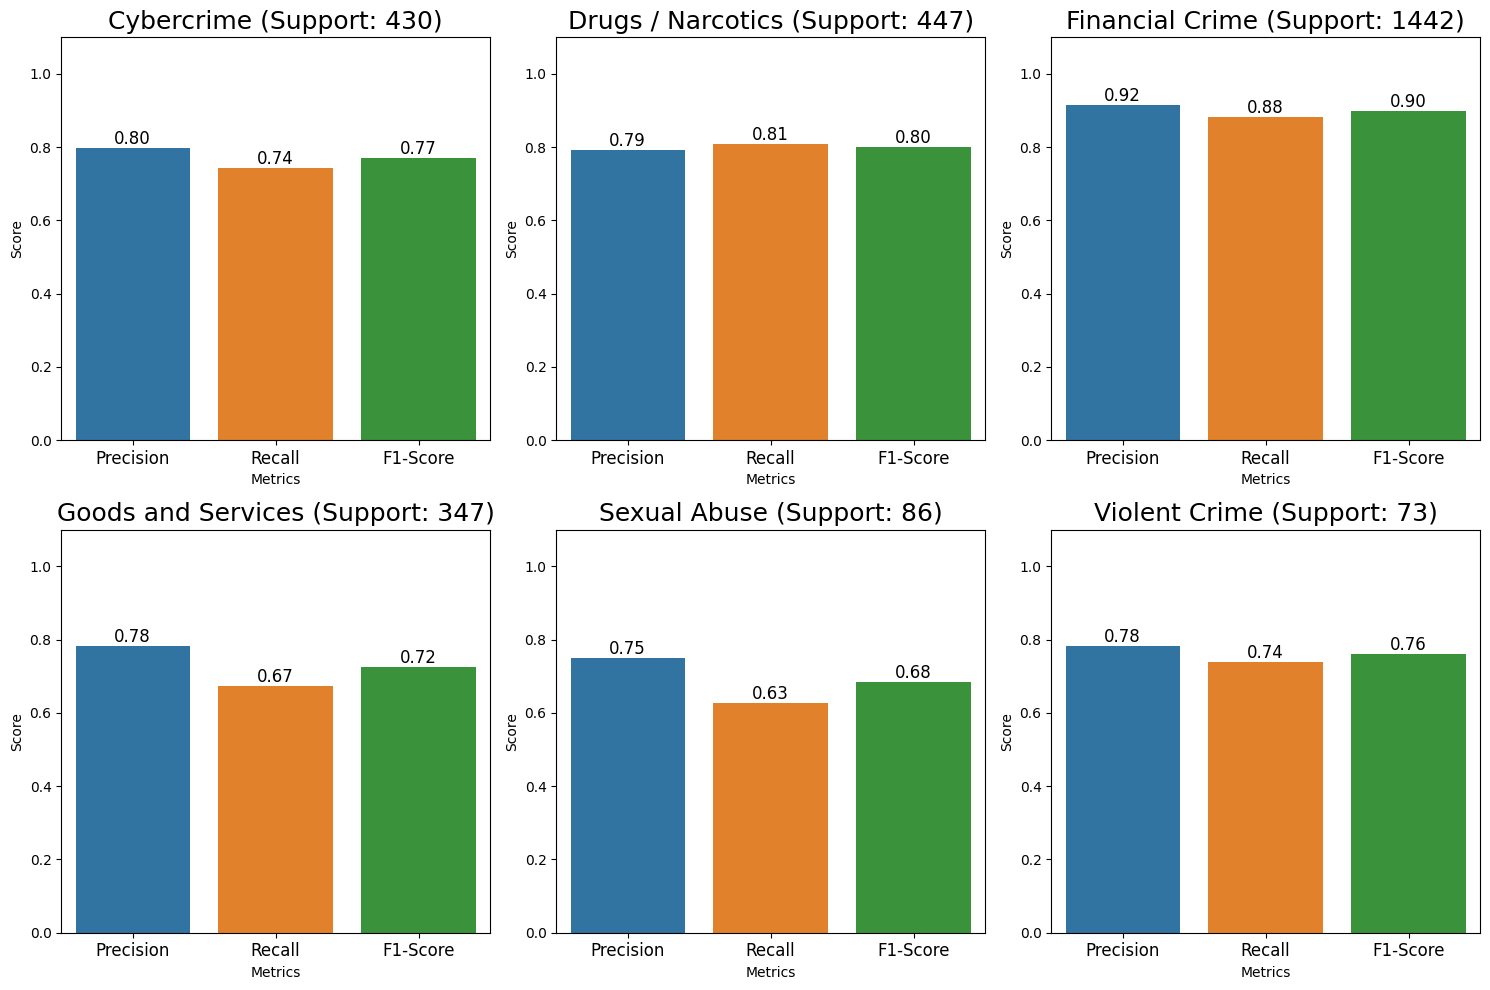

In [17]:
import seaborn as sns
plot_classification_scores(metrics['0']['32'], '/home/pablo/active-learning-pablo/results/test/active_learning/dark_wo_duplicates/classwise_perf.png')

In [5]:
import pandas as pd

from os.path import exists
import bs4
import codecs
import numpy as np
import hashlib
import sys 
sys.setrecursionlimit( 10000 )



In [12]:
dfv4 = pd.read_csv('/home/pablo/active-learning-pablo/data/datasets/cflw_large_without_duplicates_v4.csv', on_bad_lines='warn')
dfv2 = pd.read_csv('/home/pablo/active-learning-pablo/data/datasets/cflw_large_without_duplicates_v2.csv', on_bad_lines='warn')
dfv3 = pd.read_csv('/home/pablo/active-learning-pablo/data/datasets/cflw_large_without_duplicates_v3.csv', on_bad_lines='warn')
print('COlumns dfv2: ', dfv2.columns.values)
print('COlumns dfv3: ', dfv3.columns.values)
print('COlumns dfv4: ', dfv4.columns.values)

COlumns dfv2:  ['page_created_at' 'host_id' 'page_id' 'page_version_id'
 'RelatedTagsArray' 'Cybercrime' 'Drugs / Narcotics' 'Financial Crime'
 'Goods and Services' 'Sexual Abuse' 'Violent Crime' 'html' 'tree']
COlumns dfv3:  ['domain_id' 'page_id' 'page_version_id' 'RelatedTagsArray' 'Cybercrime'
 'Drugs / Narcotics' 'Financial Crime' 'Goods and Services' 'Sexual Abuse'
 'Violent Crime' 'html' 'tree']
COlumns dfv4:  ['domain_id' 'page_id' 'snapshot_id' 'RelatedTagsArray' 'Cybercrime'
 'Drugs / Narcotics' 'Financial Crime' 'Goods and Services' 'Sexual Abuse'
 'Violent Crime' 'html' 'tree']


In [13]:

dfv2['domain_id'] = dfv2['host_id']
dfv4['page_version_id'] = dfv4['snapshot_id']
dfv2 = dfv2.drop(['host_id'], axis = 1)
dfv4 = dfv4.drop(['snapshot_id'], axis = 1)
dfv2 = dfv2.drop(['page_created_at'], axis = 1)
dfv3.head()

,domain_id,page_id,page_version_id,RelatedTagsArray,Cybercrime,Drugs / Narcotics,Financial Crime,Goods and Services,Sexual Abuse,Violent Crime,html,tree
0,59816,4,3053184,"['Admin_Credentials', 'Admin_Login_Panel', 'Bu...",0,1,1,1,0,0,\n\nÐÑ Ð½Ðµ ÑÐ¾Ð±Ð¾Ñ?\n\n\n\n\n\n\n\n\n\n\...,{html {head title meta style} {body {div {for...
1,59895,40,22400801,"['Bitcoin (BTC)', 'Crypto-asset', 'English', '...",0,0,1,0,0,0,\n100x Your Coins in 24 Hours - Officially Hid...,{html {head meta meta meta meta title link li...
2,59930,48,199231619,"['Community', 'Cybercrime', 'Forum', 'Gerki Ma...",1,0,0,0,0,0,\n\n\n\n\nGerki | Теневой Форум о заработке\n\...,{html {head meta meta meta meta meta title me...
3,60064,86,2458174,"['Cannabis', 'Community', 'Drugs / Narcotics',...",0,1,0,0,0,0,\n\n\nCGMC\n\n\n\n\n\n\nCannabis Growers & Mer...,{html {head meta title link link style} {body...
4,33306,135,10910240,"['Carding', 'Credit Cards', 'English', 'Financ...",0,0,1,0,0,0,\n\n\nATM Cards\n\n\n\r\n\r\nCloned Credit Car...,{html {head meta title} {body pre}}


In [3]:
#df = pd.read_csv('/home/pablo/active-learning-pablo/data/datasets/cflw_large_without_duplicates.csv', on_bad_lines='warn')
#df.head()


,page_created_at,host_id,page_id,page_version_id,RelatedTagsArray,Cybercrime,Drugs / Narcotics,Financial Crime,Goods and Services,Sexual Abuse,Violent Crime,html,tree
0,2018-11-26 12:56:36,59895,40,26837,"['Bitcoin (BTC)', 'English', 'Financial Crime'...",0,0,1,0,0,0,\n\n\n100x Your Coins in 24 Hours - Officially...,{html {head meta meta meta meta title link li...
1,2018-11-27 00:02:10,59906,44,46435,"['English', 'Financial Crime', 'Gambling', 'Ma...",0,0,1,0,0,0,\n\nHACK-HELP\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nM...,{html {head title link link meta meta link li...
2,2018-03-27 02:31:35,59930,48,22406700,"['Community', 'Cybercrime', 'Forum', 'Gerki Ma...",1,0,0,0,0,0,\n\n\n\n\n\n\n\n\n\nGerki - ÃÂ¥ÃÂ°ÃÂºÃÂµÃ...,{html {head style meta meta meta base script ...
3,2018-11-26 11:36:05,60064,86,17558,"['Cannabis', 'Community', 'Drugs / Narcotics',...",0,1,0,0,0,0,\n\n\n\nCGMC\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\...,{html {head meta title link link style} {body...
4,2018-11-26 11:44:01,60073,88,18512,"['Carding', 'Credit Cards', 'English', 'Financ...",0,0,1,0,0,0,\n0day 1337day Agreement - 0day 1337day Inj3...,{html {head meta title meta meta link link li...


In [14]:
df_copy = pd.concat([dfv2, dfv3, dfv4])
df_copy.head()

,page_id,page_version_id,RelatedTagsArray,Cybercrime,Drugs / Narcotics,Financial Crime,Goods and Services,Sexual Abuse,Violent Crime,html,tree,domain_id
0,40,26837.0,"['Bitcoin (BTC)', 'English', 'Financial Crime'...",0,0,1,0,0,0,\n100x Your Coins in 24 Hours - Officially Hid...,{html {head meta meta meta meta title link li...,59895
1,44,46435.0,"['English', 'Financial Crime', 'Gambling', 'Ma...",0,0,1,0,0,0,\nHACK-HELP\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nMEN...,{html {head title link link meta meta link li...,59906
2,48,22406700.0,"['Community', 'Cybercrime', 'Forum', 'Gerki Ma...",1,0,0,0,0,0,\n\n\n\n\n\n\n\n\nGerki - ÃÂ¥ÃÂ°ÃÂºÃÂµÃâ...,{html {head style meta meta meta base script ...,59930
3,86,17558.0,"['Cannabis', 'Community', 'Drugs / Narcotics',...",0,1,0,0,0,0,\n\n\nCGMC\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\...,{html {head meta title link link style} {body...,60064
4,88,18512.0,"['Carding', 'Credit Cards', 'English', 'Financ...",0,0,1,0,0,0,\n0day 1337day Agreement - 0day 1337day Inj3...,{html {head meta title meta meta link link li...,60073


In [15]:

print('shape before dropping: ', df_copy.shape)
#df_copy['html'] = html_list
df_copy = df_copy.dropna()
print('shape before dropna: ', df_copy.shape)
df_copy = df_copy.drop(df_copy[df_copy["html"].map(len) == 0].index)
print('shape before drop html 0: ', df_copy.shape)
df_copy = df_copy.drop(df_copy[df_copy["html"] == '-'].index)
print('shape before drop html -: ', df_copy.shape)
df_copy = df_copy.drop(df_copy[df_copy["tree"].map(len) == 0].index)
print('shape before drop tree 0: ', df_copy.shape)
df_copy = df_copy.drop(df_copy[df_copy["tree"] == '-'].index)
print('shape before drop tree -: ', df_copy.shape)
#df_copy = df_copy.drop(df_copy[df_copy["hash"].map(len) == 0].index)
#df_copy = df_copy.drop(df_copy[df_copy["hash"] == '-'].index)
print('shape after removing empty: ', df_copy.shape)

df_copy = df_copy.drop_duplicates(subset=['html'], keep='first')
print("\n-Number of remainig samples after deduplication of html text", df_copy.shape)

#df_copy = df_copy.drop_duplicates(subset=['tree'], keep='first')
#print("\n-Number of remainig samples after deduplication of html tree", df_copy.shape)


shape before dropping:  (27331, 12)
shape before dropna:  (27331, 12)
shape before drop html 0:  (27331, 12)
shape before drop html -:  (27331, 12)
shape before drop tree 0:  (27331, 12)
shape before drop tree -:  (27331, 12)
shape after removing empty:  (27331, 12)

-Number of remainig samples after deduplication of html text (15982, 12)


In [17]:
groups = df_copy.groupby('tree').groups

In [20]:
groups.values()

dict_values([Int64Index([8483], dtype='int64'), Int64Index([5118], dtype='int64'), Int64Index([2699], dtype='int64'), Int64Index([7291], dtype='int64'), Int64Index([3222], dtype='int64'), Int64Index([6555], dtype='int64'), Int64Index([6835], dtype='int64'), Int64Index([7273], dtype='int64'), Int64Index([4958], dtype='int64'), Int64Index([36], dtype='int64'), Int64Index([5173], dtype='int64'), Int64Index([3799], dtype='int64'), Int64Index([5384], dtype='int64'), Int64Index([5925], dtype='int64'), Int64Index([6046], dtype='int64'), Int64Index([6588], dtype='int64'), Int64Index([5602], dtype='int64'), Int64Index([545], dtype='int64'), Int64Index([7027], dtype='int64'), Int64Index([5250, 7414], dtype='int64'), Int64Index([8586], dtype='int64'), Int64Index([547], dtype='int64'), Int64Index([1939], dtype='int64'), Int64Index([1352], dtype='int64'), Int64Index([1275], dtype='int64'), Int64Index([1974, 2114], dtype='int64'), Int64Index([5505], dtype='int64'), Int64Index([1667], dtype='int64'),

In [26]:
def find_pairs(dict):
    dict_len= {key: len(value) for key, value in dict.items()}
    import operator
    sorted_key_list = sorted(dict_len.items(), key=operator.itemgetter(1), reverse=True)
    sorted_dict = [dict[item [0]] for item in sorted_key_list if len(dict[item [0]]) > 1]
    return sorted_dict
pairs = find_pairs(groups)

In [27]:
pairs

[Int64Index([6572, 5258, 10717], dtype='int64'),
 Int64Index([2241, 1167, 6408], dtype='int64'),
 Int64Index([1616, 1128, 757], dtype='int64'),
 Int64Index([10, 1027, 1042], dtype='int64'),
 Int64Index([5649, 4839, 6557], dtype='int64'),
 Int64Index([42, 857, 2130], dtype='int64'),
 Int64Index([5709, 4542, 6268], dtype='int64'),
 Int64Index([6709, 5760, 8493], dtype='int64'),
 Int64Index([890, 608, 220], dtype='int64'),
 Int64Index([167, 606, 7], dtype='int64'),
 Int64Index([160, 458, 48], dtype='int64'),
 Int64Index([888, 604, 256], dtype='int64'),
 Int64Index([6234, 6563, 7154], dtype='int64'),
 Int64Index([5749, 4623, 6390], dtype='int64'),
 Int64Index([3982, 3094, 593], dtype='int64'),
 Int64Index([6116, 5067, 8514], dtype='int64'),
 Int64Index([6242, 6466, 7163], dtype='int64'),
 Int64Index([8650, 6378, 9814], dtype='int64'),
 Int64Index([5620, 1639, 5522], dtype='int64'),
 Int64Index([7875, 5367, 7683], dtype='int64'),
 Int64Index([6127, 4334, 7050], dtype='int64'),
 Int64Index([

In [46]:
df_copy.iloc[757]['html']

"\n\n\nTorPharm   \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\r\n        \t\t\t    TorPharm                    \ntorpharmzxholobn.onion\n\n\n\nHome\nOrder Status\nFAQ\nTorPharmRX\nAbout\n\n\n\n\ncurrency\nUSD\n\n\n\n\r\n\t\t\t\t\t\tUSD\t\t\t\t\t\n\n\n\r\n\t\t\t\t\t\tEUR\t\t\t\t\t\n\n\n\r\n\t\t\t\t\t\tGBP\t\t\t\t\t\n\n\n\n \nlanguages\n\n\n\n\n\n en\n\n\n \n\n\n\n\n\nViagra 10 pills x 100 mg\n+\nCialis 10 pills x 20 mg\n\n\n\r\n                        Special Offer                    \n\r\n                        only 55.04$ for package                    \n\nBUY NOW\n\n\n\n\n\n\n\n\nA\n\n\nB\n\n\nC\n\n\nD\n\n\nE\n\n\nF\n\n\nG\n\n\nH\n\n\nI\n\n\r\n\t\t\t\t\t\t\tJ\t\t\t\t\t\n\nK\n\n\nL\n\n\nM\n\n\nN\n\n\nO\n\n\nP\n\n\r\n\t\t\t\t\t\t\tQ\t\t\t\t\t\n\nR\n\n\nS\n\n\nT\n\n\nU\n\n\nV\n\n\nW\n\n\nX\n\n\nY\n\n\nZ\n\n \n\n\n\n\n\n\nSearch\n\n\n\n\n\n\n\n\n\n\n\n\n \nCategories\n\n\n\nAnti Alcohol\n\n\nWeight Loss\n\n\nAnxiety\n\n\nAnti Convulsant\n\n\nBestsellers\n\n\nGastrointestinal Tract\n\n\

In [21]:
def sort_by_values_len(dict):
    dict_len= {key: len(value) for key, value in dict.items()}
    import operator
    sorted_key_list = sorted(dict_len.items(), key=operator.itemgetter(1), reverse=True)
    sorted_dict = [{item[0]: dict[item [0]]} for item in sorted_key_list]
    return sorted_dict

sorted_groups = sort_by_values_len(groups)
sorted_groups

[{' {html {body p title meta meta meta meta link link {div {div {div img} {div {div a {ul {li a} {li a} {li a} {li a} {li a} {li a}}} div}}} br {div {ul {strong span}}} {div {div br {div {strong span} {table {thead {tr th th th th th}} {tbody {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}} {tr td td td {td span} {td a}}}}}}} {p a} {div p}}}': Int64Index([6572, 5258, 10717], dtype='int64')},
 {' {html {body p title meta meta meta meta link link {div {div {

In [47]:
df_copy.head()

,page_id,page_version_id,RelatedTagsArray,Cybercrime,Drugs / Narcotics,Financial Crime,Goods and Services,Sexual Abuse,Violent Crime,html,tree,domain_id
0,40,26837.0,"['Bitcoin (BTC)', 'English', 'Financial Crime'...",0,0,1,0,0,0,\n100x Your Coins in 24 Hours - Officially Hid...,{html {head meta meta meta meta title link li...,59895
1,44,46435.0,"['English', 'Financial Crime', 'Gambling', 'Ma...",0,0,1,0,0,0,\nHACK-HELP\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nMEN...,{html {head title link link meta meta link li...,59906
2,48,22406700.0,"['Community', 'Cybercrime', 'Forum', 'Gerki Ma...",1,0,0,0,0,0,\n\n\n\n\n\n\n\n\nGerki - ÃÂ¥ÃÂ°ÃÂºÃÂµÃâ...,{html {head style meta meta meta base script ...,59930
3,86,17558.0,"['Cannabis', 'Community', 'Drugs / Narcotics',...",0,1,0,0,0,0,\n\n\nCGMC\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\...,{html {head meta title link link style} {body...,60064
4,88,18512.0,"['Carding', 'Credit Cards', 'English', 'Financ...",0,0,1,0,0,0,\n0day 1337day Agreement - 0day 1337day Inj3...,{html {head meta title meta meta link link li...,60073


In [48]:
df_all = df_copy.merge(df.drop_duplicates(), on=df.columns.values.tolist(), 
                   how='left', indicator=True)
df_all.head()

NameError: name 'df' is not defined

In [10]:
df_all.shape

(13422, 14)

In [8]:
new_values = df_all.loc[df_all['_merge'] == 'left_only']
new_values.head()

,page_created_at,host_id,page_id,page_version_id,RelatedTagsArray,Cybercrime,Drugs / Narcotics,Financial Crime,Goods and Services,Sexual Abuse,Violent Crime,html,tree,_merge
10238,2019-10-01 14:02:27,59816,4.0,3053184.0,"['Admin_Credentials', 'Admin_Login_Panel', 'Bu...",0.0,1.0,1.0,1.0,0.0,0.0,\n\nÐÑ Ð½Ðµ ÑÐ¾Ð±Ð¾Ñ?\n\n\n\n\n\n\n\n\n\n\...,{html {head title meta style} {body {div {for...,left_only
10239,2022-03-17 09:43:31,59930,48.0,199231619.0,"['Community', 'Cybercrime', 'Forum', 'Gerki Ma...",1.0,0.0,0.0,0.0,0.0,0.0,\n\n\n\n\n\n\n\nGerki | Теневой Форум о зарабо...,meta {meta {html {head meta meta meta title {...,left_only
10240,2019-05-16 01:53:32,60064,86.0,2458174.0,"['Cannabis', 'Community', 'Drugs / Narcotics',...",0.0,1.0,0.0,0.0,0.0,0.0,\n\n\n\nCGMC\n\n\n\n\n\n\nCannabis Growers & M...,{html {head meta title link link style} {body...,left_only
10241,2022-07-13 01:27:31,51859,138.0,232301709.0,"['Cybercrime', 'English', 'Hacking', 'Service ...",1.0,0.0,0.0,0.0,0.0,0.0,\n\nXhacker\n\n\n\n\n\n\n\n\n\n=\n\n\n\n[ xHac...,{html {head title meta {meta meta link style}...,left_only
10242,2022-07-09 13:53:27,51912,151.0,231483544.0,"['English', 'Financial Crime', 'Gambling', 'Ma...",0.0,0.0,1.0,0.0,0.0,0.0,\n\n\n\n\nXmatches - fixed football matches\n\...,{html {head meta meta title meta meta link {l...,left_only


In [9]:
for i in range(len(df_copy['page_created_at'])):

    new_values[i, 'page_created_at'] = new_values[i, 'page_created_at'][ 0: 10]

KeyError: (0, 'page_created_at')

In [14]:
df_copy.to_csv('/home/pablo/active-learning-pablo/data/datasets/cflw_large4_with_trees.csv', index=False)